<a href="https://colab.research.google.com/github/rrrayhan/MTCars/blob/main/MTCars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mtcars:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3225%2F5297%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240326%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240326T221945Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1325701d94266017c031cc2d3f2feb73d9131f013873e1de07cc8be1da8db485ff168417af4ab9f542fc886191287850365d39f03c8f77daa33f0d889fa3e828d68d1ef864d808e70fb0f099c5d11940524abfa8b176aab89f7ee916f61df71706cd48947d036f4fe8fcabea2cfa0924a43b1c4fcc7cff0e479e14783e0ba736fc71d20b655c7819d42e53636e4bf7f278faa3812f17af457eeaae6bce0e0396c2c6267635f787b083a74d68384551d8e9fee8bffa49f1c1e1d1e22edabaa94550b7bd638ffb0bdc8a8b38600ee21dbd85b49cbc7c6745f998067d9db08e609fcf2eaf29eeea9555beb44e0d1991490332cc43604dc61d85ca225c6b1432ad45'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 999 bytes downloaded
Downloaded and uncompressed: mtcars
Data source import complete.


# **MTCars Analysis (Bahasa Indonesia)**

**Pendahuluan**
1. Import Libraries yang dibutuhkan
2. Membaca data yang dimiliki
3. Mengecek jika ada data yang kosong
4. Mencari korelasi antar kolom data

**Pertanyaan**
1. Model mobil mana yang memiliki *top speed* tertinggi berdasarkan *horsepower*?
2. Model transmisi mana yang baik berdasarkan mpg?
3. Berapa silinder yang baik untuk mobil berdasarkan *horsepower*?
4. Silinder mana yang paling banyak digunakan untuk setiap transmisi?
5. Tipe mesin mana yang paling cepat untuk menempuh 1/4 mil (QSEC)?

**Kesimpulan**

# **Pendahuluan**

**1. Import *Libraries* yang dibutuhkan**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**2. Membaca data yang dimiliki**

In [3]:
df = pd.read_csv('/kaggle/input/mtcars/mtcars.csv')
df1 = df.copy()
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [4]:
print('Dataset information:')
df.info()
print('\nDataset shape:', df.shape)

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     int64  
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     int64  
 9   am      32 non-null     int64  
 10  gear    32 non-null     int64  
 11  carb    32 non-null     int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB

Dataset shape: (32, 12)


**3. Mengecek jika ada data yang kosong**

In [5]:
print('Counting total missing value:', df.isna().sum().sum())

Counting total missing value: 0


**4. Mencari korelasi antar kolom data**

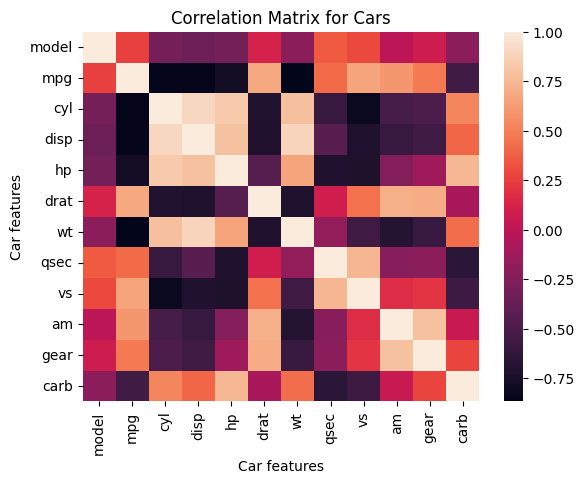

In [ ]:
df_numerized = df

for model in df_numerized.columns:
    if(df_numerized[model].dtype == 'object'):
        df_numerized[model]= df_numerized[model].astype('category')
        df_numerized[model] = df_numerized[model].cat.codes

correlation_matrix = df_numerized.corr(method = 'pearson')

sns.heatmap(correlation_matrix, annot = False)
plt.title("Correlation Matrix for Cars")
plt.xlabel("Car features")
plt.ylabel("Car features")
plt.show()

# **Isi**

**1. Model mobil mana yang memiliki *top speed* tertinggi berdasarkan *horsepower*?**

Untuk mencari *top speed* berdasarkan *horsepower*, penulis mendapatkan rumus sebagai berikut:

*top speed* (mph) = 20 * akar pangkat dua dari *horsepower*

Contoh: 400hp; akar pangkat dua adalah 7,36; dikalikan 20 adalah 147mph.

sumber: https://www.quora.com/How-does-one-calculate-the-approximate-maximum-speed-of-a-vehicle-using-its-stats-Specifically-using-engine-HP-weight-torque-and-RPM

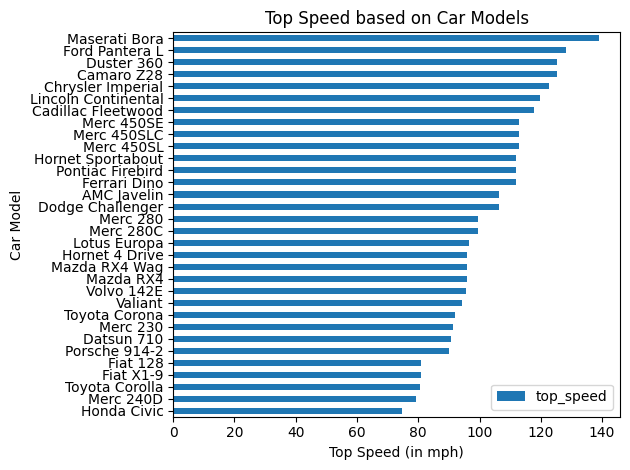

In [ ]:
df1['top_speed']=(np.power((df['hp']),1/3)*20)
df_top_speed = df1.sort_values(by='top_speed')
df_top_speed.plot(x='model', y='top_speed', kind='barh', title='Top Speed based on Car Models')
plt.xlabel('Top Speed (in mph)')
plt.ylabel('Car Model')
plt.tight_layout()
plt.show()

Berdasarkan chart diatas, model mobil Maserati Bora memiliki *top speed* tercepat sebesar 138.9 mph atau 223.5 kph, sedangkan model mobil Honda Civic memiliki *top speed* terlambat sebesar 74.6 mph atau 120 kph. Hal ini berarti membuktikan bahwa **kecepatan** suatu mobil dipengaruhi oleh ***horsepower***-nya.

**2. Model transmisi mana yang baik berdasarkan mpg?**

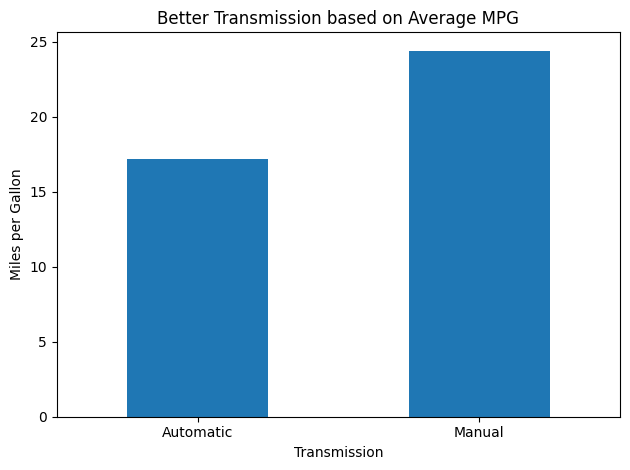

In [ ]:
df_am = df.groupby(['am'])['mpg'].mean()
df_am.plot(x='am', y='mpg', kind='bar', title='Better Transmission based on Average MPG')
plt.xlabel('Transmission')
plt.ylabel('Miles per Gallon')
labels, locations = plt.xticks()
plt.xticks(np.arange(2), ('Automatic','Manual'), rotation=0)
plt.tight_layout()
plt.show()

Berdasarkan chart diatas, transmisi manual dapat menempuh sekitar 24.8 mil per galon bensin, sedangkan transmisi automatic hanya dapat menempuh sekitar 17 mil per galon bensin saja. Hal ini membuktikan bahwa mobil yang memakai **transmisi manual** cenderung **lebih hemat bensin** dibandingkan mobil yang memakai transmisi automatic.

**3. Berapa silinder yang baik untuk mobil berdasarkan *horsepower*?**

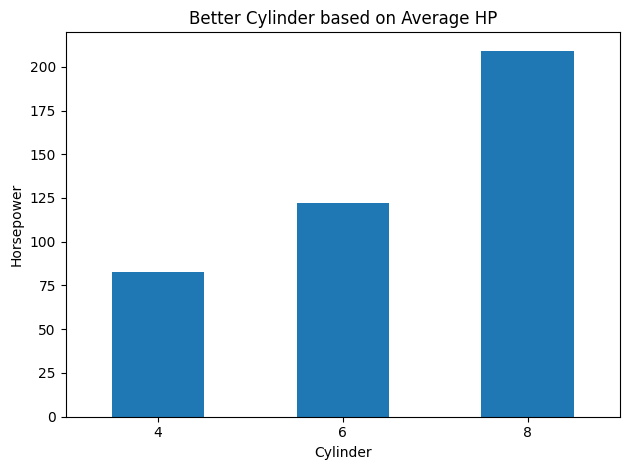

In [ ]:
df_am = df.groupby(['cyl'])['hp'].mean()
df_am.plot(x='am', y='mpg', kind='bar', title='Better Cylinder based on Average HP')
plt.xlabel('Cylinder')
plt.ylabel('Horsepower')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Berdasarkan chart diatas, mobil dengan **8 silinder rata-rata memiliki *horsepower* yang tinggi**. Mengacu pada pertanyaan 1, hal ini juga membuktikan bahwa mobil dengan 8 silinder mempunyai kecepatan yang tinggi juga. Sebaliknya, mobil dengan 4 silinder memiliki *horsepower* yang rendah.

**4. Silinder mana yang paling banyak digunakan untuk setiap transmisi?**

<Figure size 640x480 with 0 Axes>

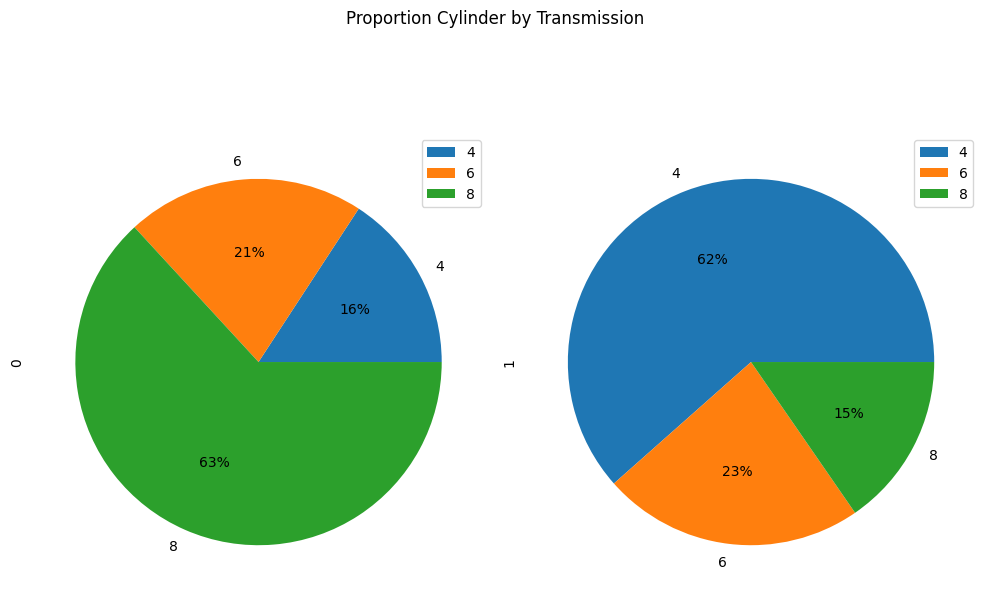

In [ ]:
plt.clf()
df_piv = df.pivot_table(index='cyl',
                        columns='am',
                        values='model',
                        aggfunc='count',
                        fill_value=0)
df_piv.plot.pie(subplots=True,
                figsize=(10, 7),
                layout=(-1, 2),
                autopct='%1.0f%%',
                title='Proportion Cylinder by Transmission')
plt.tight_layout()
plt.show()

Berdasarkan chart diatas, 63% mobil yang menggunakan transmisi **automatic** memiliki mesin **8 silinder**, sedangkan 62% mobil yang menggunakan transmisi **manual** memiliki mesin **4 silinder**.

**Keterangan:**
0 = Automatic,
1 = Manual

**5. Tipe mesin (V/S) mana yang paling cepat untuk menempuh 1/4 mil (QSEC)?**

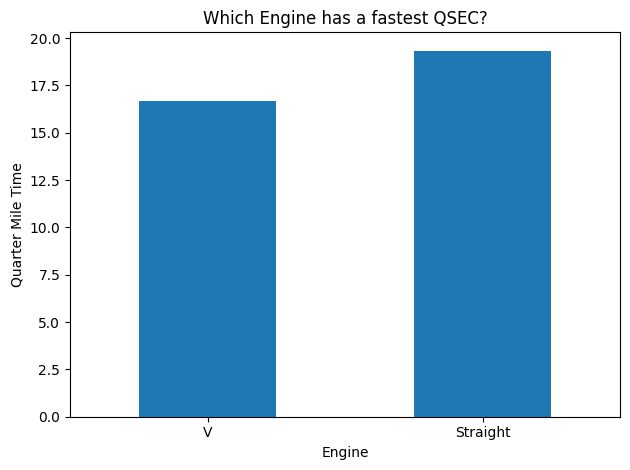

In [ ]:
df_am = df.groupby(['vs'])['qsec'].mean()
df_am.plot(x='vs', y='qsec', kind='bar', title='Which Engine has a fastest QSEC?')
plt.xlabel('Engine')
plt.ylabel('Quarter Mile Time')
labels, locations = plt.xticks()
plt.xticks(np.arange(2), ('V','Straight'), rotation=0)
plt.tight_layout()
plt.show()

Berdasarkan chart diatas, tipe mesin *straight shape* dapat menempuh 1/4 mil dengan waktu sekitar 19 detik, sedangkan tipe mesin *V-shape* dapat menempuh 1/4 mil dengan waktu sekitar 17 detik saja. Hal ini membuktikan **mobil dengan tipe mesin *V-shape* cenderung lebih cepat** dibandingkan dengan mobil dengan tipe mesin *straight shape*.

# **Kesimpulan**

Berdasarkan data yang telah dianalisa, kecepatan mobil dipengaruhi oleh besarnya *horsepower* yang dimiliki mobil tersebut. Semakin banyak silinder yang ada dalam mesin mobil, semakin besar juga *horsepower*-nya. Hal ini dibuktikan dengan kebanyakan mobil yang punya mesin 8 silinder memiliki *horsepower* yang tinggi juga. Lalu, 63% mobil yang memakai transmisi automatic adalah mobil yang punya mesin 8 silinder, sedangkan 62% mobil yang memakai transmisi manual adalah mobil yang punya mesin 4 silinder. Hal ini membuktikan, kebanyakan mobil yang memakai transmisi automatic, memiliki *horsepower* yang tinggi juga. Mobil yang memakai transmisi manual cenderung lebih hemat bensin dibandingkan mobil dengan transmisi automatic. Mobil dengan tipe mesin *V-shape* cenderung lebih cepat dibandingkan dengan mobil tipe mesin *straight shape*.

Secara singkat mobil dengan transmisi manual lebih unggul dalam penggunaan bensin dibandingkan transmisi automatic. Mobil dengan transmisi automatic lebih unggul dalam kecepatan dibandingkan transmisi manual.